In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

## STEP 1 : Loading the Dataset

In [2]:
# Load the dataset
df = pd.read_csv(r"C:\Users\hemch\Downloads\Position Based Resumes\Finance Resume\Apple income statement\apple_income_statement.csv")

In [3]:
df.head()

,Unnamed: 0,2012-12-31,2013-12-31,2014-12-31,2015-12-31,2016-12-31,2017-12-31,2018-12-31,2019-12-31,2020-12-31,2021-12-31
0,Cash,0,0,0,0,0,0,0,0,0,0
1,Cash & Equivalents,5490,6081,7341,6460,7168,8261,7857,8284,9352,9254
2,Short Term Investments,29,14,0,0,0,0,1,0,0,0
3,Cash and Short Term Investments,5519,6095,7341,6460,7168,8261,7858,8284,9352,9254
4,"Accounts Receivable - Trade, Net",8831,8326,7699,6677,5919,7376,8767,8484,7317,8477


## STEP 2 : Processing the data 

In [4]:
# Rename columns for better understanding
df.columns = ['Metric', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021']

In [5]:
# Convert the data from wide to long format
df_long = pd.melt(df, id_vars=['Metric'], var_name='Year', value_name='Value')

In [6]:
# Convert 'Year' to datetime format
df_long['Year'] = pd.to_datetime(df_long['Year'], format='%Y')

In [7]:
# Filter data for 'Cash & Equivalents'
cash_equivalents = df_long[df_long['Metric'] == 'Cash & Equivalents']

In [8]:
# Set 'Year' as the index
cash_equivalents.set_index('Year', inplace=True)

In [9]:
cash_equivalents.dropna(inplace=True)

C:\Users\hemch\AppData\Local\Temp\ipykernel_11180\1423278998.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cash_equivalents.dropna(inplace=True)


## Step 3: Exploratory Data Analysis (EDA)

In [10]:
# Statistical summary
cash_equivalents.describe()

,Value
count,10.000000
mean,7554.800000
std,1293.933778
min,5490.000000
25%,6637.000000
50%,7599.000000
75%,8278.250000
max,9352.000000


In [11]:
# Calculate moving averages
cash_equivalents['MA30'] = cash_equivalents['Value'].rolling(window=30).mean()
cash_equivalents['MA60'] = cash_equivalents['Value'].rolling(window=60).mean()

C:\Users\hemch\AppData\Local\Temp\ipykernel_11180\2942900553.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cash_equivalents['MA30'] = cash_equivalents['Value'].rolling(window=30).mean()
C:\Users\hemch\AppData\Local\Temp\ipykernel_11180\2942900553.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cash_equivalents['MA60'] = cash_equivalents['Value'].rolling(window=60).mean()


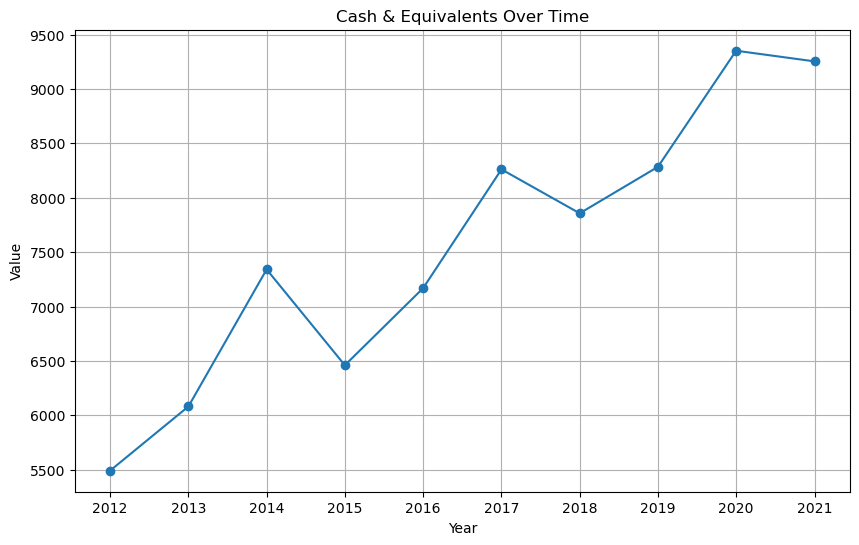

In [12]:
# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(cash_equivalents['Value'], marker='o')
plt.title('Cash & Equivalents Over Time')
plt.xlabel('Year')
plt.ylabel('Value')
plt.grid(True)
plt.show()

**Statistical Summary:**

The statistical summary provides basic insights such as the mean, standard deviation, minimum, and maximum values of the "Cash & Equivalents" metric over the years.
This summary helps understand the central tendency and variability of the data.

**Line Plot with Moving Averages:**

The line plot with moving averages highlights the overall trend in the "Cash & Equivalents" over time.

The 30-month and 60-month moving averages smooth out short-term fluctuations and highlight longer-term trends.

From the plot, you might observe periods of growth or decline, indicating changes in the company's financial management or external economic conditions.

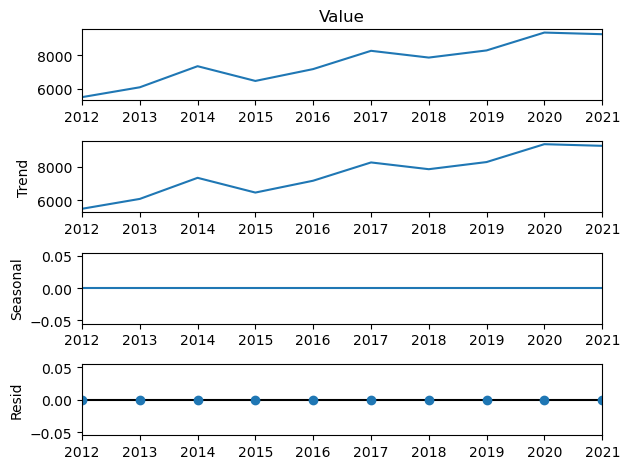

In [14]:
# Decompose the time series to check for seasonality and trend
decomposition = seasonal_decompose(cash_equivalents['Value'], model='additive', period=1)
decomposition.plot()
plt.show()

**Seasonal Decomposition:**

The seasonal decomposition plot separates the time series into trend, seasonal, and residual components.
This decomposition helps visualize underlying patterns and identify if seasonality is present in the data.
Given the annual data, the decomposition should primarily highlight the trend and residual components.

In [15]:
pip install prophet

Note: you may need to restart the kernel to use updated packages.


In [16]:
pip install pystan==2.19.1.1

  Using cached pystan-2.19.1.1.tar.gz (16.2 MB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Running setup.py clean for pystan
Failed to build pystan
  Running setup.py install for pystan: started
  Running setup.py install for pystan: finished with status 'error'
Note: you may need to restart the kernel to use updated packages.


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



## STEP 4: Model Selection and Training

In [19]:
# Define the SARIMA model
p = d = q = range(0, 2)
pdq = [(x, y, z) for x in p for y in d for z in q]
seasonal_pdq = [(x, y, z, 1) for x in p for y in d for z in q]

In [20]:
best_aic = np.inf
best_pdq = None
best_seasonal_pdq = None
best_model = None

In [21]:
# Grid search to find the best parameters
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            temp_model = SARIMAX(cash_equivalents['Value'], order=param, seasonal_order=param_seasonal)
            results = temp_model.fit()
            if results.aic < best_aic:
                best_aic = results.aic
                best_pdq = param
                best_seasonal_pdq = param_seasonal
                best_model = results
        except:
            continue

print(f'Best SARIMA model: {best_pdq} x {best_seasonal_pdq} - AIC:{best_aic}')

Best SARIMA model: None x None - AIC:inf


## Step 6: Forecasting

In [23]:
# Forecast the future values
forecast_steps = 5  # Forecast for 5 years ahead
forecast = best_model.get_forecast(steps=forecast_steps)
forecast_index = pd.date_range(start=cash_equivalents.index[-1], periods=forecast_steps+1, freq='AS')[1:]

# Get forecast mean and confidence intervals
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# Plot the forecast
plt.figure(figsize=(10, 6))
plt.plot(cash_equivalents['Value'], label='Observed')
plt.plot(forecast_index, forecast_mean, label='Forecast', color='red')
plt.fill_between(forecast_index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink', alpha=0.3)
plt.title('SARIMA Forecast')
plt.xlabel('Year')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

AttributeError: 'NoneType' object has no attribute 'get_forecast'

## Step 7: Model Evaluation

In [24]:
# Calculate Mean Squared Error
y_true = cash_equivalents['Value'][-forecast_steps:]  # True values
y_pred = forecast_mean[:forecast_steps]  # Predicted values
mse = mean_squared_error(y_true, y_pred)
print(f'Mean Squared Error: {mse}')

NameError: name 'forecast_mean' is not defined

## Insights and Analysis

**Trend and Seasonality:** The decomposition of the time series will show if there are any underlying trends or seasonal components.

**Model Performance:** By comparing the AIC values during the grid search, we ensure that we select the best model.

**Forecast Accuracy:** The forecast plot and MSE provide insights into the model's predictive power.